In [26]:
import pandas as pd
import pickle as pkl
import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc
%matplotlib inline
import matplotlib

### Read in dataset

In [27]:
data_df = pd.read_csv('/dfs/user/yhr/research_assistant/datasets/ground_truth_Scharenberg22.csv')
topmovers = np.load('/dfs/user/yhr/research_assistant/datasets/topmovers_Scharenberg22.npy')
all_genes = data_df['Gene'].values

### Random baseline

In [28]:
def generate_random_rounds(all_genes, round0=None, rounds = 16, sample_size=64):
    past_set =list(all_genes)
    random_rounds = {}
    if round0 is not None:
        random_rounds[0] = round0
    else:
        random_rounds[0] = np.random.choice(all_genes, sample_size)
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_size)])
        past_set = list(selection_set)
        
    return random_rounds

def generate_random_rounds_custom(all_genes, rounds = 16, sample_sizes=None):
    past_set =list(all_genes)
    random_rounds = {}
    random_rounds[0] = []
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_sizes[i])])
        past_set = list(selection_set)
        
    return random_rounds

def return_hits(list_):
    return list(set(list_).intersection(set(topmovers)))

def get_all_sampled_genes(exp_path, num_rounds = 100):
    all_sampled_genes = []
    for i in range(1,num_rounds):
        exp_path_ = exp_path + str(i) + '.npy'
        all_sampled_genes.append(np.load(exp_path_))
    return all_sampled_genes

def get_successful_sample_sizes(sampled_genes):
    sizes = []
    prev_size = 0
    for sample in sampled_genes:
        sizes.append(len(sample)-prev_size)
        prev_size = prev_size + sizes[-1]
    return sizes

def return_hits(arr):
    return list(set(arr).intersection(set(topmovers)))

### Equal sampling: Claude

In [36]:
import glob

exp_paths = {
 '1':'/dfs/user/yhr/research_assistant/logs_Scharenberg22/exp4/sampled_genes_',
 '2':'/dfs/user/yhr/research_assistant/logs_Scharenberg22/exp5/sampled_genes_',
 '3':'/dfs/user/yhr/research_assistant/logs_Scharenberg22/exp6/sampled_genes_',
}

In [37]:
sampled_genes = {}
sample_sizes = {}
hits = {}
hit_rates = {}
num_rounds = 50
filter_zero_sets = True

for rep in range(1, len(exp_paths)+1):
    rep = str(rep)
    sampled_genes[rep] = get_all_sampled_genes(exp_paths[rep], num_rounds=num_rounds)
    sample_sizes[rep] = get_successful_sample_sizes(sampled_genes[rep])
    if filter_zero_sets:
         sampled_genes[rep] = [sampled_genes[rep][itr] for itr in np.where(np.array(sample_sizes[rep])!= 0)[0]]
    
    hits[rep] = []
    hit_rates[rep] = []
    hits[rep] = [return_hits(x) for x in sampled_genes[rep]]
    hit_rates[rep] = [len(x)/len(topmovers) for x in hits[rep]]

<BarContainer object of 49 artists>

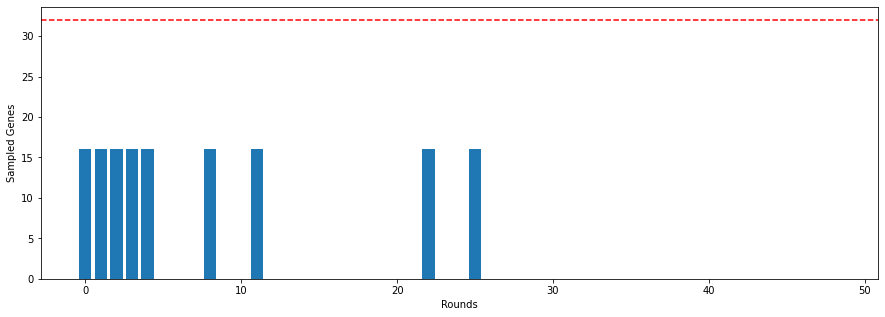

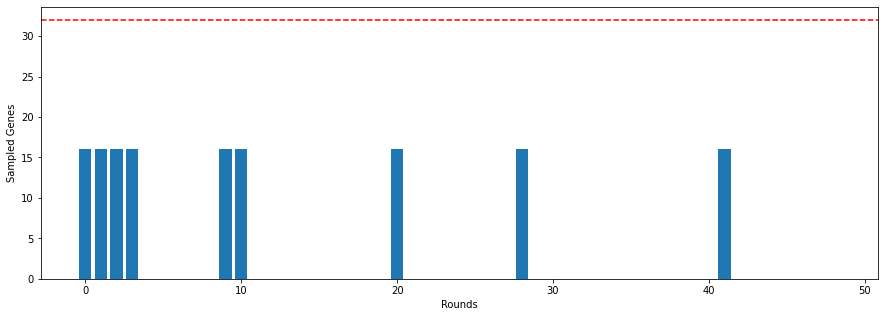

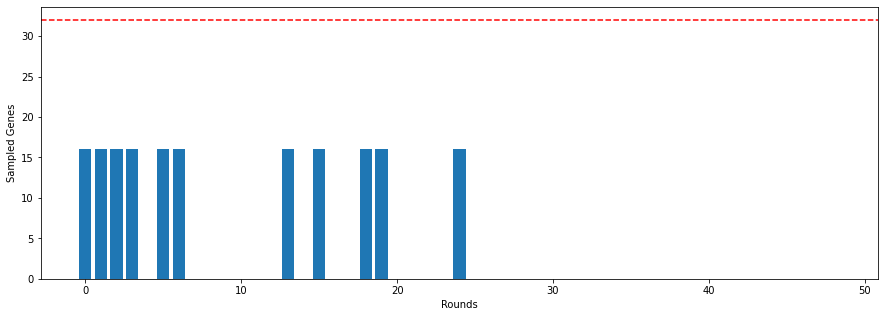

In [38]:
## GPT has trouble counting

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['1'])

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['2'])

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['3'])

In [41]:
num_steps = np.min([len(x) for x in sampled_genes.values()]) -1
num_reps = 3
sample_size=16

In [42]:
random_rounds = {}
random_hits = {}
random_hit_rates = {}

for rep in range(1, len(exp_paths)+1):
    rep=str(rep)
    random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
    #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
    #                                                   sample_sizes=sample_sizes[rep])
    
    random_hits[rep] = []
    random_hit_rates[rep] = []
    for step in range(num_steps):
        random_hits[rep].append(return_hits(random_rounds[rep][step]))
        random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))

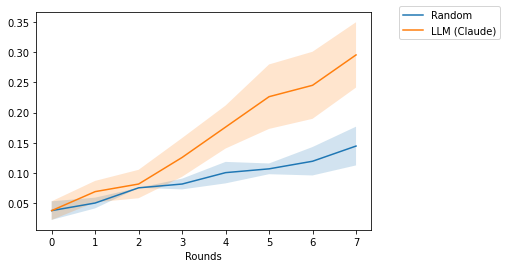

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# calculate the mean and standard deviation of the random data
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)


ai_ra_mean = np.mean(np.array([x[:num_steps] for x in hit_rates.values()]),0)
ai_ra_std = np.std(np.array([x[:num_steps] for x in hit_rates.values()]),0)


# create the plot
plt.plot(np.arange(num_steps), random_mean, label='Random')
plt.fill_between(np.arange(num_steps), random_mean - random_std, 
                         random_mean + random_std, alpha=0.2)

# add the GPT data to the plot
plt.plot(np.arange(num_steps), ai_ra_mean, label='LLM (Claude)')
plt.fill_between(np.arange(num_steps), ai_ra_mean - ai_ra_std, 
                             ai_ra_mean + ai_ra_std, alpha=0.2)

# set the x-axis labels and tick marks
plt.xlabel('Rounds')

# add a legend to the plot
plt.legend(bbox_to_anchor=(1.4, 1.05))

# display the plot
plt.show()